Script that we used to import the data from Marmoset Brain Connectivity Atlas
(http://www.marmosetbrain.org) using their public web API http://www.marmosetbrain.org/api/v1/injections

We used our warping fields to map the data to our STPT image reference space, and to
map the data to flatmap stacks. To facilitate validation and further usage of the data, we also share 
intermediate files (mapped injection site locations and cell locations) as pickle file.




In [7]:
MBCA_working_dir=".../MBCA/"
BMCR_data="..."
fmapstack_mapping=BMCR_data+"/auxiliary_data/fmapstack_pipeline/results/"


In [8]:
import pickle
OUT_data =  MBCA_working_dir+'/point_map/inj.p'
all_cells_loaded = pickle.load( open( OUT_data, "rb" ) )

# The location of all injection site in STPT reference space
# all_cells_loaded["injection_sites"] 
# Further data for each injection site can be found under
# all_cells_loaded["injection_site"]["0"]
# all_cells_loaded["injection_site"]["1"]
# all_cells_loaded["injection_site"][...

In [1]:
import subprocess
import math
import sys
import argparse #https://docs.python.org/2/library/argparse.html
import json
import time
import datetime
import os
import re
import nibabel as nib
import numpy as np
import urllib, json
import requests
import pandas as pd
from IPython.display import clear_output
import sys
import matplotlib.pyplot as plt
import matplotlib as mpl
import csv
import glob
import nibabel as nib
from IPython.display import clear_output

import pickle
dpi_default = mpl.rcParams['figure.dpi']
from IPython.display import clear_output
def bash_run(command):

        proc = subprocess.Popen(['/bin/bash'],text=True ,stdin=subprocess.PIPE, stdout=subprocess.PIPE,stderr=subprocess.PIPE)
        return proc.communicate(command) , (proc.returncode == 0)
#http://www.marmosetbrain.org/api/v1/injections

from collections import OrderedDict
def json_read(filename):
        if (os.path.isfile(filename)):
            with open(filename) as data_file:
                data = json.load(data_file, object_pairs_hook=OrderedDict)
            isfile=True;
        else:
            data={}
            isfile=False;
        return data, isfile    
    
def json_write(data,filename):
        with open(filename, 'w') as data_file:
            json.dump(data, data_file, indent=4, sort_keys=False, separators=(',', ':'))

In [2]:
# ############################################
# Original brain regions from the Marmoset Brain Connectivity Atlas
# ############################################
MBCA_atlas=MBCA_working_dir+'/atlas/atlas_segmentation.nii.gz'
ref_img = nib.load(MBCA_atlas)
ref_img.shape


(825, 63, 550)

In [8]:
# ############################################
# To download the retrograde data, we use the http://www.marmosetbrain.or web API
# ############################################
url='http://www.marmosetbrain.org/api/v1/injections'
injections = requests.post(url).json()

In [3]:
#STPT template version (STPT_template_nora.nii.gz)
ref_STPT =  nib.load(BMCR_data+'/Atlas/STPT_template_nora.nii.gz')

145


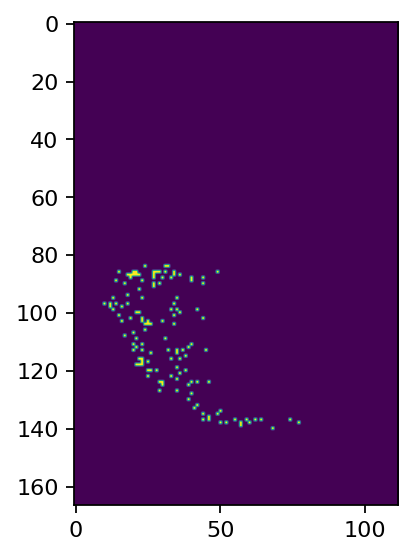

 /disk/soft//ANTS/bin//antsApplyTransformsToPoints -d 3   -i  /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/MBCA/point_map/inj_sites_MBCA_std.csv   -o  /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/MBCA/point_map/inj_sites_TC_std.csv    -t /disk/skibbe/nextcloud/BIA/Henrik/Marmonet/Public/Atlas_STPT/MBCA/trafo/STPT_2_MBCA.h5 
 /disk/soft//ANTS/bin//antsApplyTransformsToPoints -d 3   -i  /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/MBCA/point_map/inj_sites_TC_std.csv   -o  /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/MBCA/point_map/inj_sites_fmap_MBM.csv    -t /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/results/MBM/ants/flatmap_stack_trafo_l_1_inverse.nii.gz
 /disk/soft//ANTS/bin//antsApplyTransformsToPoints -d 3   -i  /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/MBCA/point_map/inj_sites_TC_std.csv   -o  /disk/k_raid/KAKUSHIN-NOU-DATA/database/model/fmapstack_pipeline/M

/tmp/ipykernel_3614738/273966682.py:90: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)


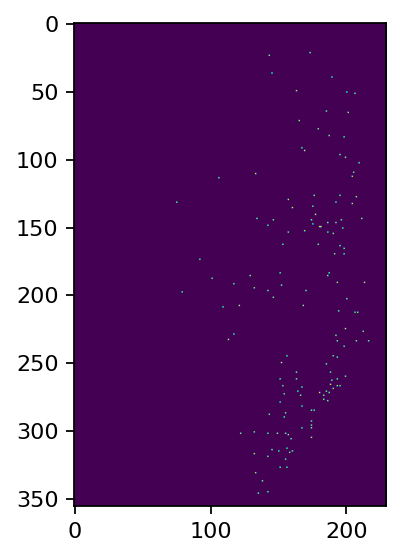

/tmp/ipykernel_3614738/273966682.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)


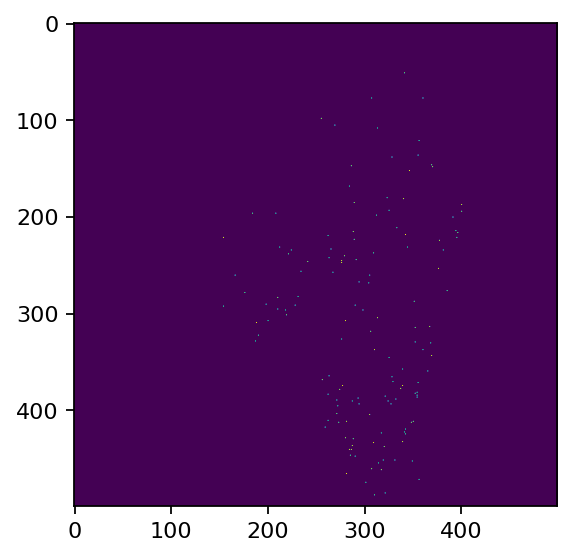

/tmp/ipykernel_3614738/273966682.py:137: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)


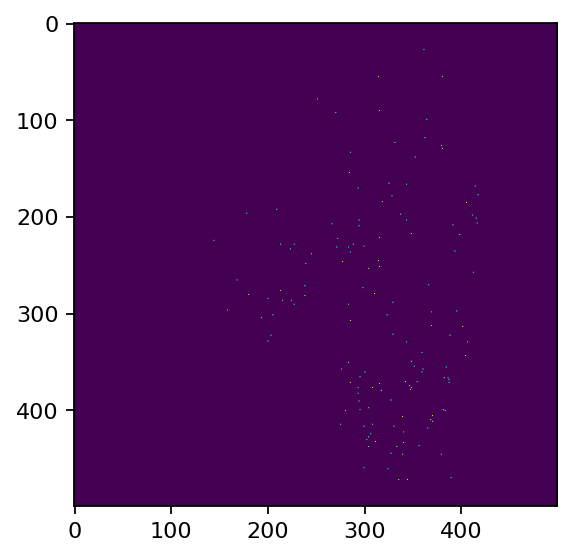

In [9]:
# ############################################
# We download the injection site locations and cell locations
# We first map the injection sites  to our STPT reference space
# ############################################

if True:
    
    positions = []
    for mdata in injections['injections']:
        positions += [[float(mdata["M-L"]),float(mdata["A-P"]),float(mdata["D-V"])]] 
        
    fn = MBCA_working_dir+'/point_map/'
    
    print(len(positions))
    assert(len(positions) > 0)
    if len(positions) > 0:
        ref_img =  nib.load(MBCA_working_dir+'/inj/CJ19-FE_all_cells.nii.gz')
        positions_3D = np.array(positions)
        positions_3D_ants = positions_3D * 1
        positions_3D_ants[:,1] = -positions_3D_ants[:,1]

        positions_3D[:,0] = -positions_3D[:,0]
        
        T = ref_img.header.get_sform()
        P = np.concatenate((positions_3D,np.ones([positions_3D.shape[0],1])),axis=1)
        P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 

        valid = np.all((P[:,:3]+1)<ref_img.shape,axis=1)
        Pr = np.round(P[valid,:]).astype(np.int64)
        
        img = np.zeros(ref_img.shape)

        if True:
            for p in range(Pr.shape[0]):
                img[Pr[p,0],Pr[p,1],Pr[p,2]] += 1


            nii = nib.Nifti1Image(img, ref_img.affine)#, ref_STPT.header)
            nib.save(nii,fn+'./org_inj_sites.nii.gz')

            mpl.rcParams['figure.dpi'] = 160
            pdim = 1
            img = img.max(axis=pdim)[:,:,None]
            img = img / img.max()

            plt.imshow(img,vmin=0,vmax=1)
            plt.pause(0.1)

        OUT =  MBCA_working_dir+'/point_map/inj_sites_TC_std.csv'
        
        if True:
            MOVE = MBCA_working_dir+'/point_map/inj_sites_MBCA_std.csv'
            csv_out = MOVE
            with open(csv_out, 'w', newline='') as csvfile:
                fieldnames = ['x', 'y', 'z', 't']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for p in range(positions_3D_ants.shape[0]):
                    #p = positions[pi,:]
                    #if len(p) > 1:
                    #pts = (-float(row['x']),-float(row['y']),float(0))
                    writer.writerow({'x': positions_3D_ants[p,0], 'y': positions_3D_ants[p,1],'z':positions_3D_ants[p,2], 't':0})

            
            TRAFO = BMCR_data+'/Atlas_STPT/MBCA/trafo/STPT_2_MBCA.h5'
            

            cmd = [' /disk/soft//ANTS/bin//antsApplyTransformsToPoints','-d 3  ',
            '-i ',MOVE,' ',
            '-o ',OUT,' ',
            ' -t '+TRAFO+' ']
            cmd = " ".join(cmd)
            print(cmd)
            bash_run(cmd)

            if True:
                for atlas in ["MBM","BMA"]:
                    TRAFO2 = fmapstack_mapping+'/'+atlas+'/ants/flatmap_stack_trafo_l_1_inverse.nii.gz'
                    #OUT2 =  MBCA_working_dir+'/point_map/'+atlas+'/fmstack/'+inj_id+'.csv'
                    OUT2 =  MBCA_working_dir+'/point_map/inj_sites_fmap_'+atlas+'.csv'
                    cmd = [' /disk/soft//ANTS/bin//antsApplyTransformsToPoints','-d 3  ',
                    '-i ',OUT,' ',
                    '-o ',OUT2,' ',
                    ' -t '+TRAFO2]
                    cmd = " ".join(cmd)
                    print(cmd)
                    bash_run(cmd)



        if True:

            file = pd.read_csv(OUT) 
            positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)
            positions_std[:,:2] = - positions_std[:,:2]

            T = ref_STPT.header.get_sform()
            P = np.concatenate((positions_std,np.ones([positions_std.shape[0],1])),axis=1)
            P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 

            valid = np.all(P[:,:3]<ref_STPT.shape,axis=1)
            Pr = np.round(P[valid,:]).astype(np.int64)

            img = np.zeros(ref_STPT.shape)
            
            img_r = np.array(ref_STPT.get_fdata())


            if True:
                for p in range(Pr.shape[0]):
                    #img[img.shape[0]-Pr[p,0],img.shape[1]-Pr[p,1],Pr[p,2]] += 1
                    img[Pr[p,0],Pr[p,1],Pr[p,2]] += 1


                nii = nib.Nifti1Image(img, ref_STPT.affine)#, ref_STPT.header)
                nib.save(nii,fn+'./std_inj_sites.nii.gz')
                
                mpl.rcParams['figure.dpi'] = 160
                pdim = 0
                img_r = img_r.max(axis=pdim)[:,:,None]
                img_r = img_r / img_r.max()
                img = img.max(axis=pdim)[:,:,None]
                img = img / img.max()

                #blend = np.concatenate((img_r,img,img_r),axis=2)
                #plt.imshow(blend,vmin=0,vmax=1)
                plt.imshow(img,vmin=0,vmax=1)
                plt.pause(0.1)

       



        if True:
            for atlas in ["MBM","BMA"]:
                OUT2 =  MBCA_working_dir+'/point_map/inj_sites_fmap_'+atlas+'.csv'
                
                ref_fstack = nib.load(fmapstack_mapping+atlas+'/ants/flatmap_stack_trafo_l_2.nii.gz')
    
                file = pd.read_csv(OUT2) 
                positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)
                positions_std[:,:2] = - positions_std[:,:2]

                T = ref_fstack.header.get_sform()
                P = np.concatenate((positions_std,np.ones([positions_std.shape[0],1])),axis=1)
                P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 

                valid = np.all((P[:,:3]+0.5)<ref_fstack.shape[:3],axis=1)
                valid = np.logical_and(valid,np.all(P[:,:3]>0,axis=1))
                Pr = np.round(P[valid,:]).astype(np.int64)

                img = np.zeros(ref_fstack.shape[:3])

                if True:
                    for p in range(Pr.shape[0]):
                        img[Pr[p,0],Pr[p,1],Pr[p,2]] += 1

                    nii = nib.Nifti1Image(img, ref_fstack.affine)#, ref_STPT.header)
                    nib.save(nii,fn+'/'+atlas+'_fstack_inj_sites.nii.gz')

                    mpl.rcParams['figure.dpi'] = 160
                    pdim = 2
                    img_r = img_r.max(axis=pdim)[:,:,None]
                    img_r = img_r / img_r.max()
                    img = img.max(axis=pdim)[:,:,None]
                    img = img / img.max()

                    plt.imshow(img,vmin=0,vmax=1)
                    plt.pause(0.1)        


In [11]:
ref_STPT_full =  nib.load(BMCR_data+'/Atlas_STPT/STPT/STPT_template.nii.gz')

In [17]:
# ############################################
# This function is used to map the retrograde cells to our
#  STPT image space
# ############################################

def create_data(atlas,cell_info,inj_id):

    fn = MBCA_working_dir+'/point_map/'

    if True:
        positions = [] 
        layer = []
        for c in cell_info['cells']:
            pos = [float(m) for m in c[4:7]]
            layer += [int(c[7])]
            #pos[0] *= -1
            positions +=  [pos]
        print(len(positions))
        assert(len(positions) > 0)
        print(inj_id)
        ref_img =  nib.load(MBCA_working_dir+'/inj/CJ19-FE_all_cells.nii.gz')
        positions_3D = np.array(positions)
        positions_3D = positions_3D[:,:3]
        positions_3D_ants = positions_3D * 1

        if False:
            positions_3D[:,:2] = -positions_3D[:,:2]
            T = ref_img.header.get_sform()
            P = np.concatenate((positions_3D,np.ones([positions_3D.shape[0],1])),axis=1)
            P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 

            valid = np.all((P[:,:3]+1)<ref_img.shape,axis=1)

            Pr = np.round(P[valid,:]).astype(np.int64)

        OUT =  MBCA_working_dir+'/point_map/std/'+inj_id+'.csv'

        # ############################################
        # MAP points to STPT
        # ############################################
        if True:
            MOVE = MBCA_working_dir+'/point_map/in/'+inj_id+'.csv'
            csv_out = MOVE
            with open(csv_out, 'w', newline='') as csvfile:
                fieldnames = ['x', 'y', 'z', 't']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                for p in range(positions_3D_ants.shape[0]):
                    writer.writerow({'x': positions_3D_ants[p,0], 'y': positions_3D_ants[p,1],'z':positions_3D_ants[p,2], 't':0})

            TRAFO = BMCR_data+'/Atlas_STPT/MBCA/trafo/STPT_2_MBCA.h5'
            

            cmd = [' /disk/soft//ANTS/bin//antsApplyTransformsToPoints','-d 3  ',
            '-i ',MOVE,' ',
            '-o ',OUT,' ',
            ' -t '+TRAFO+' ']
            cmd = " ".join(cmd)
            print(cmd)
            bash_run(cmd)


        # ############################################
        # Create density images in STPT image space
        # ############################################
        if False:
            file = pd.read_csv(OUT) 
            positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)
            positions_std[:,:2] = - positions_std[:,:2]

            T = ref_STPT.header.get_sform()
            P = np.concatenate((positions_std,np.ones([positions_std.shape[0],1])),axis=1)
            P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 

            valid = np.all(P[:,:3]<ref_STPT.shape,axis=1)
            Pr = np.round(P[valid,:]).astype(np.int64)

            img = np.zeros(ref_STPT.shape)
            img_infragranular = np.zeros(ref_STPT.shape)
            img_supragranular = np.zeros(ref_STPT.shape)
            
            img_r = np.array(ref_STPT.get_fdata())
            if True:
                for p in range(Pr.shape[0]):
                    img[Pr[p,0],Pr[p,1],Pr[p,2]] += 1
                    if layer[p] > 0 :
                        img_supragranular[Pr[p,0],Pr[p,1],Pr[p,2]] += 1
                    else:
                        img_infragranular[Pr[p,0],Pr[p,1],Pr[p,2]] += 1

                nii = nib.Nifti1Image(img, ref_STPT.affine)#, ref_STPT.header)
                nib.save(nii,fn+'./std/'+inj_id+'_all_cells.nii.gz')
                nii = nib.Nifti1Image(img_supragranular, ref_STPT.affine)#, ref_STPT.header)
                nib.save(nii,fn+'./std/'+inj_id+'_supragranular.nii.gz')
                nii = nib.Nifti1Image(img_infragranular, ref_STPT.affine)#, ref_STPT.header)
                nib.save(nii,fn+'./std/'+inj_id+'_infragranular.nii.gz')
                
                mpl.rcParams['figure.dpi'] = 160
                pdim = 2
                img_r = img_r.max(axis=pdim)[:,:,None]
                img_r = img_r / img_r.max()
                img = img.max(axis=pdim)[:,:,None]
                img = img / img.max()

                #blend = np.concatenate((img_r,img,img_r),axis=2)
                #plt.imshow(blend,vmin=0,vmax=1)
                plt.imshow(img,vmin=0,vmax=1)
                plt.pause(0.1)




In [ ]:
# ############################################
# This function maps the retrograde cells to our
#  STPT image space
# ############################################


for mdata in injections['injections']:
    clear_output(wait=True)

    inj_id = mdata['id']
    if not os.path.isfile(MBCA_working_dir+'/point_map/std/'+inj_id+'.csv'):
        url='http://www.marmosetbrain.org/api/v1/cells?injection_id='+inj_id
        cell_info = requests.post(url).json()
        print(" ",inj_id," ",inj_id)
        create_data(atlas,cell_info,inj_id)
        
        
        

In [ ]:
# ############################################
# Here we store our working data in a pickle file
# ############################################


all_cells = {}

OUT =  MBCA_working_dir+'/point_map/inj_sites_TC_std.csv'
file = pd.read_csv(OUT) 
positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)
positions_std[:,:2] = - positions_std[:,:2]

T = ref_STPT_full.header.get_sform()
P = np.concatenate((positions_std,np.ones([positions_std.shape[0],1])),axis=1)
P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 
all_cells["injection_sites"] = {"location_std":P[:,:3]}

all_cells["injection_site"] = {}
for mdata,indx in zip(injections['injections'],range(len(injections['injections']))):
        print(indx,"  ",len(injections['injections']))
        cdata = {}
        clear_output(wait=True)
        inj_id = mdata['id']
        url='http://www.marmosetbrain.org/api/v1/cells?injection_id='+inj_id
        cell_info = requests.post(url).json()
        
        
        OUT =  MBCA_working_dir+'/point_map/std/'+inj_id+'.csv'
        assert(os.path.isfile(OUT))
        if os.path.isfile(OUT):
            file = pd.read_csv(OUT) 
            positions_std = np.array(file.iloc[:,:3]).astype(dtype=np.float)
            positions_std[:,:2] = - positions_std[:,:2]

            T = ref_STPT_full.header.get_sform()
            P = np.concatenate((positions_std,np.ones([positions_std.shape[0],1])),axis=1)
            P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 
        
            layer = []
            for c in cell_info['cells']:
                layer += [int(c[7])]

            positions = np.concatenate((P[:,:3],np.array(layer)[:,None]),axis=1)
            cdata["positions"] = positions
        cdata["meta"] = mdata
        cdata["injection_site"] = all_cells["injection_sites"]["location_std"][indx,:]
        all_cells["injection_site"][str(indx)] = cdata 
        
import pickle
OUT_data =  MBCA_working_dir+'/point_map/inj.p'
pickle.dump( all_cells, open( OUT_data, "wb" ) )
all_cells_loaded = pickle.load( open( OUT_data, "rb" ) )    

In [4]:
# ############################################
# 
# We can continue from our pickled data
#
# ############################################

import pickle
OUT_data =  MBCA_working_dir+'/point_map/inj.p'
all_cells_loaded = pickle.load( open( OUT_data, "rb" ) )

In [21]:
# ############################################
# 
# Creating data for the BMCR-Explorere
#
# ############################################


shape3D = ref_STPT_full.shape 

for mdata,indx in zip(injections['injections'],range(len(injections['injections']))):
    clear_output(wait=True)
    inj_id = mdata['id']
    fdn =  MBCA_working_dir+'/point_map/web/'+inj_id+"/"
    
    if "positions" in all_cells["injection_site"][str(indx)]:
        os.makedirs(fdn,exist_ok=True) 
        #std_files = [f for f in listdir(join(db_folder,MID,'tissuecyte/slice/reg/'+std_ref_files+'/')) if (isfile(join(db_folder,MID,'tissuecyte/slice/reg/'+std_ref_files+'/',f)) and ("png" in f))] 
        P = all_cells["injection_site"][str(indx)]["positions"]
        P_inj = all_cells["injection_site"][str(indx)]["injection_site"]
        print(positions.shape[0])
        print(P_inj)

        #std_files.sort()
        if True:
            for s in range(shape3D[1]):
                #print(s)
                z_ind = shape3D[1] - (1+s)

                valid = np.abs(P[:,1]-z_ind)<1.0
                P_ = P[valid,:]

                has_inj = np.abs(P_inj[1]-z_ind)<10.0
                r =11-np.abs(P_inj[1]-z_ind)
                #P_[:,0] = shape2D[0] -  P_[:,0]
                #P_[:,2] = shape3D[2] -  P_[:,2]

                #positions_3D = np.concatenate((positions_3D,P_[:,:3]),axis=0)  

                #OUT_std = join(db_folder,MID,'tissuecyte/slice/reg/'+dest_dir+'/',s.replace('png','csv'))
                OUT_std = fdn + "/"+str(10000+s)+".csv"
                with open(OUT_std, 'w', newline='') as csvfile:
                    fieldnames = ['x', 'y','z','r']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)


                    for pi in range(P_.shape[0]):
                        p = P_[pi,:]
                        writer.writerow({'x':p[0],  'y':p[2],'z':1 if p[3]==1 else 2,'r':10})
                    if has_inj:
                        p = P_inj
                        writer.writerow({'x':p[0],  'y':p[2],'z':3,'r':3*r+10})    


            print("done")
            OUT_std = fdn + "/shape.csv"
            with open(OUT_std, 'w', newline='') as csvfile:
                    fieldnames = ['x', 'y']
                    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                    writer.writerow({'x':shape3D[0],  'y':shape3D[2]})    
            
  #  break

43632
[164.95011511 585.81475653 347.62538048]
done


In [43]:
# ############################################
# 
# Creating data for the BMCR-Explorere
#
# ############################################
jsonf = {}
jsonf2 = {}
order = []
    
for mdata,indx in zip(injections['injections'],range(len(injections['injections']))):
    clear_output(wait=True)
    inj_id = mdata['id']
    fdn =  MBCA_working_dir+'/point_map/web/'+inj_id+"/"
    
    if "positions" in all_cells["injection_site"][str(indx)]:
        meta = all_cells["injection_site"][str(indx)]["meta"]
    
    
    mdata = {
        "folder":meta["id"],
        "global_html_uid":[
            "TC_MBCA_HTML"
        ],
        "html":"",
        "html_uid":meta["id"],
        "img":0,
        "imgbutton":"RET",
        "key":meta["id"],
        "labelbutton":"RET",
        "mod_key":"TC_R_STD",
        "overlay":1,
        "pol_overlay":0
    }
    jsonf["MBCA"+meta["id"]] = mdata
    
    jsonf2[meta["id"]] = {
        #"type":["MBCA",meta["id"]+"-["+meta["area"]+"]"]
        "type":["MBCA",meta["area"]+"-["+meta["id"]+"]"]
    }
    order += [{"id":meta["id"],"area":meta["area"]+"-["+meta["id"]+"]"}]
    
    #print(meta)
    
    #break

jsonf2["order"]= [a["id"] for a in sorted(order, key=lambda d: d["area"])]
    
json_write(jsonf,MBCA_working_dir+"/point_map/web.json")
json_write(jsonf2,MBCA_working_dir+"/point_map/web2.json")

In [352]:

ref_STPT_tiny =  nib.load(BMCR_data+'/Atlas_STPT/STPT/STPT_template_ttiny.nii.gz')
print(ref_STPT_tiny.header["pixdim"])
ref_STPT =  nib.load(BMCR_data+'/Atlas_STPT/STPT/STPT_template_small.nii.gz')
print(ref_STPT.header["pixdim"])


[1.  0.4 0.4 0.4 1.  1.  1.  1. ]
[1.  0.1 0.1 0.1 1.  1.  1.  1. ]


In [ ]:
# ############################################
# 
# Creating cell density 3D image stacks
# Creating cell density flatmap stacks
#
# ############################################


ref_STPT_tiny =  nib.load(BMCR_data+'/Atlas_STPT/STPT/STPT_template_ttiny.nii.gz')
fn = MBCA_working_dir+'/point_map/'
for mdata,indx in zip(injections['injections'],range(len(injections['injections']))):
    clear_output(wait=True)
    inj_id = mdata['id']
    if "positions" in all_cells["injection_site"][str(indx)]:
        if True:
            meta = all_cells["injection_site"][str(indx)]["meta"]
            positions_vox = all_cells["injection_site"][str(indx)]["positions"][:,:3]

            layer = all_cells["injection_site"][str(indx)]["positions"][:,3]
            T = ref_STPT_full.header.get_sform()
            T2 = ref_STPT_tiny.header.get_sform()
            P = np.concatenate((positions_vox,np.ones([positions_vox.shape[0],1])),axis=1)
            P = np.transpose(np.matmul(T,np.transpose(P))) 
            P = np.transpose(np.matmul(np.linalg.pinv(T2),np.transpose(P))) 

            valid = np.all((P[:,:3]+0.5)<ref_STPT_tiny.shape[:3],axis=1)
            valid = np.logical_and(valid,np.all(P[:,:3]>0,axis=1))
            Pr = np.round(P[valid,:]).astype(np.int64)
            
            positions_vox = all_cells["injection_site"][str(indx)]["injection_site"][None,:]
            P = np.concatenate((positions_vox,np.ones([positions_vox.shape[0],1])),axis=1)
            P = np.transpose(np.matmul(T,np.transpose(P))) 
            P = np.transpose(np.matmul(np.linalg.pinv(T2),np.transpose(P))) 
            Pri = np.round(P).astype(np.int64)

            img = np.zeros(ref_STPT_tiny.shape[:3])
            img_inj = np.zeros(ref_STPT_tiny.shape[:3])
            img_infragranular = np.zeros(ref_STPT_tiny.shape[:3])
            img_supragranular = np.zeros(ref_STPT_tiny.shape[:3])
            #img_r = np.array(ref_STPT_tiny.get_fdata())


            if True:
                img_inj[Pri[0,0],Pri[0,1],Pri[0,2]] += 1
                for p in range(Pr.shape[0]):
                    #img[img.shape[0]-Pr[p,0],img.shape[1]-Pr[p,1],Pr[p,2]] += 1
                    img[Pr[p,0],Pr[p,1],Pr[p,2]] += 1
                    #img[Pr[p,0],Pr[p,1],Pr[p,2]] = 0
                    if layer[p] > 0 :
                        img_supragranular[Pr[p,0],Pr[p,1],Pr[p,2]] += 1
                    else:
                        img_infragranular[Pr[p,0],Pr[p,1],Pr[p,2]] += 1

                nii = nib.Nifti1Image(img, ref_STPT_tiny.affine)#, ref_STPT.header)
                nib.save(nii,fn+'/std_ttiny/'+inj_id+'.nii.gz')
                nii = nib.Nifti1Image(img_supragranular, ref_STPT_tiny.affine)#, ref_STPT.header)
                nib.save(nii,fn+'/std_ttiny/'+inj_id+'_supragranular.nii.gz')
                nii = nib.Nifti1Image(img_infragranular, ref_STPT_tiny.affine)#, ref_STPT.header)
                nib.save(nii,fn+'/std_ttiny/'+inj_id+'_infragranular.nii.gz')
                nii = nib.Nifti1Image(img_inj, ref_STPT_tiny.affine)#, ref_STPT.header)
                nib.save(nii,fn+'/std_ttiny/'+inj_id+'_inj.nii.gz')
                if False:
                    mpl.rcParams['figure.dpi'] = 160
                    pdim = 2
                    img_r = img_r.max(axis=pdim)[:,:,None]
                    img_r = img_r / img_r.max()
                    img = img.max(axis=pdim)[:,:,None]
                    img = img / img.max()

                    #blend = np.concatenate((img_r,img,img_r),axis=2)
                    #plt.imshow(blend,vmin=0,vmax=1)
                    plt.imshow(img,vmin=0,vmax=1)
                    plt.pause(0.1)      
        if True:
            for atlas in ["MBM","BMA"]:
                ifiles =  [fn+'/std_ttiny/'+inj_id+'.nii.gz',fn+'/std_ttiny/'+inj_id+'_supragranular.nii.gz',fn+'/std_ttiny/'+inj_id+'_infragranular.nii.gz',fn+'/std_ttiny/'+inj_id+'_inj.nii.gz'] 
                opre = ["_l.nii.gz","_l_supragranular.nii.gz",'_l_infragranular.nii.gz','_l_inj.nii.gz']
                for a in range(4):
                    TRAFO2 = fmapstack_mapping+atlas+'/ants/flatmap_stack_trafo_l_4.nii.gz'
                    OUT2 =  MBCA_working_dir+'/stacks_'+atlas+'_ttiny/'+inj_id+opre[a]
                    cmd = [' /disk/soft//ANTS/bin//antsApplyTransforms','-d 3 --float  ',
                    '-i ',ifiles[a],' ',
                    '-o ',OUT2,' ',
                    ' -t '+TRAFO2,
                    ' -r '+TRAFO2,]
                    cmd = " ".join(cmd)
                    print(cmd)
                    bash_run(cmd)
        #P = np.transpose(np.matmul(np.linalg.pinv(T),np.transpose(P))) 
        
       # break
